In [1]:
import sys, os

import matplotlib  
matplotlib.use('Agg')  
from matplotlib import pyplot as plt
from matplotlib.pyplot import savefig

%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from scipy.io import loadmat, savemat

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_null',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import numpy as np
from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand

print "I'm using scipy version:" 
scipy.__version__

I'm using scipy version:


'0.13.3'

In [73]:
#### self-defined functions to find fluxes shifted between different sampling distributions
#from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
#from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore

import fluxShift
reload(fluxShift)
from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
from fluxShift import get_met_sum_flux,gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore


In [3]:
model = cobra.io.load_json_model("HNC47.json")
react_id = "RecombinantProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Recombinant protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0

metabolites = ['ala__L_c','cys__L_c','asp__L_c','glu__L_c','phe__L_c','gly_c','his__L_c','ile__L_c','lys__L_c','leu__L_c','met__L_c','asn__L_c','pro__L_c','gln__L_c','arg__L_c','ser__L_c','thr__L_c','val__L_c','trp__L_c','tyr__L_c','atp_c','adp_c','pi_c']

coefficient1 = [-6,-6,-9,-17,-9,-11,-5,-4,-17,-17,-3,-11,-19,-11,-6,-24,-14,-23,-4,-8,-4.306*224,964.544,965.544]
coefficient2 = [-0.513689,-0.09158,-0.241055,-0.26316,-0.185265,-0.612638,-0.094738,-0.290529,-0.343161,-0.450531,-0.153686,-0.241055,-0.221055,-0.26316,-0.295792,-0.215792,-0.253687,-0.423162,-0.056843,-0.137896,-23.03053,23.03053,23.03053]

for i in range(0,len(metabolites)):
 metabolite = model.metabolites.get_by_id(metabolites[i])
 reaction.add_metabolites({metabolite:coefficient2[i]}) 

reaction.gene_reaction_rule = ''
model.add_reaction(reaction)

react_id = "BiomassProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Biomass protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0
for i in range(0,len(metabolites)):
  metabolite = model.metabolites.get_by_id(metabolites[i])
  reaction.add_metabolites({metabolite:coefficient2[i]}) 

model.add_reaction(reaction)


In [4]:
m = model.copy()
m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
m.reactions.EX_glc__D_e.lower_bound = -0.5

# Find Loops/zero flux reactions in M model
loops = []
read_to_struct =[]
for r in m.reactions:
    r.objective_coefficient = 1.0  
    m.optimize()
    if m.solution.f > 100:
        read_to_struct.append({'reaction':r.id, 'flux':m.solution.f})
        loops.append(r.id)
    
    r.objective_coefficient = 0

DF_erroneous_fluxes = pd.DataFrame(read_to_struct)

#  search for zero flux reactions

opt_fract = 0.9
m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1

from cobra.flux_analysis.variability import flux_variability_analysis
flux_var = flux_variability_analysis(m,fraction_of_optimum=opt_fract)

removed = []
read_to_struct = []

for r in m.reactions:
    # 1 fix numerical errors
    if flux_var[r.id]['minimum'] > flux_var[r.id]['maximum']:
        min_val = np.round(flux_var[r.id]['minimum'],9)
        max_val = np.round(flux_var[r.id]['maximum'],9)
        flux_var[r.id]['minimum'] = max_val
        flux_var[r.id]['maximum'] = min_val
        
    # 2 constrain bounds to FVA results
    r.lower_bound = flux_var[r.id]['minimum']
    r.upper_bound = flux_var[r.id]['maximum']
    
    # 3 remove reactions that cannot carry flux
    if r.lower_bound==0 and r.upper_bound==0:
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
        m.optimize()
        
        if m.solution.f == None:
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'no'})
        else:
            removed.append(r.id)
            m.remove_reactions(r)
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'yes'})
            
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0   
        
DF_zero_flux_reactions = pd.DataFrame(read_to_struct)


cobra/core/Model.py:306 UserWarning: need to pass in a list


In [5]:
## Remove reactions from sampling dataframes
reactions_to_remove = DF_zero_flux_reactions.reaction[DF_zero_flux_reactions['removed?']=='yes'].tolist() + DF_erroneous_fluxes.reaction.tolist()
print "number of total reactions:", len(DF_zero_flux_reactions[DF_zero_flux_reactions['removed?']=='yes'])+len(DF_erroneous_fluxes.reaction)


number of total reactions: 768


In [6]:
# load R sybil MCMC sampling trajectories into ipython
from collections import defaultdict

def mcmc_tab2pandas(strain):

    file1 = '25glucose+10YE/sampling_%s_p1.tab'%strain
    file2 = '25glucose+10YE/sampling_%s_p2.tab'%strain
    file3 = '25glucose+10YE/sampling_%s_p3.tab'%strain
    
    flux_dist1 = np.loadtxt(file1,delimiter="\t",skiprows=1)
    flux_dist2 = np.loadtxt(file2,delimiter="\t",skiprows=1)
    flux_dist3 = np.loadtxt(file3,delimiter="\t",skiprows=1)

    print "Sample size for %s phase I:"%strain, flux_dist1.shape
    print "Sample size for %s phase II:"%strain, flux_dist2.shape
    print "Sample size for %s phase III:"%strain, flux_dist3.shape
    
    # now convert flux_dist array into pandas df with reaction field
    
    model_rxns=[]

    samples1 = defaultdict(list)
    samples2 = defaultdict(list)
    samples3 = defaultdict(list)
    
    tmp_array = []
    for react in model.reactions:
        tmp_array.append(react.id)

    count = 0
    for i in tmp_array:
        rxn_name = str(i)
        model_rxns.append(str(i))
    
        samples1[rxn_name] = flux_dist1[count,:]
        samples2[rxn_name] = flux_dist2[count,:]
        samples3[rxn_name] = flux_dist3[count,:]
    
        count +=1

    # convert to dataframes    
    df_samples1 = pd.DataFrame(samples1)
    df_samples2 = pd.DataFrame(samples2)
    df_samples3 = pd.DataFrame(samples3)  

    print "number of reactions in df:", len(model_rxns)

    return (df_samples1,df_samples2,df_samples3)

################################################################################


In [74]:
mcmc_reduced_dict_p1 = {}
mcmc_reduced_dict_p2 = {}
mcmc_reduced_dict_p3 = {}

mcmc_p1_dict = {}
mcmc_p2_dict = {}
mcmc_p3_dict = {}

In [75]:
mylegend = ['50%glc','25%glc_10%YE']

In [76]:
for strain in mylegend:
    (mcmc_p1_dict[strain],mcmc_p2_dict[strain],mcmc_p3_dict[strain]) = mcmc_tab2pandas(strain)
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    df_reduced_p2 = remove_unwanted_rxns(mcmc_p2_dict[strain],reactions_to_remove)
    df_reduced_p3 = remove_unwanted_rxns(mcmc_p3_dict[strain],reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    mcmc_reduced_dict_p2[strain] = df_reduced_p2
    mcmc_reduced_dict_p3[strain] = df_reduced_p3
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p2[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p3[strain].shape


Sample size for 50%glc phase I: (2786, 5000)
Sample size for 50%glc phase II: (2786, 5000)
Sample size for 50%glc phase III: (2786, 5000)
number of reactions in df: 2786
Strain 50%glc (5000, 2018)
Strain 50%glc (5000, 2018)
Strain 50%glc (5000, 2018)
Sample size for 25%glc_10%YE phase I: (2786, 5000)
Sample size for 25%glc_10%YE phase II: (2786, 5000)
Sample size for 25%glc_10%YE phase III: (2786, 5000)
number of reactions in df: 2786
Strain 25%glc_10%YE (5000, 2018)
Strain 25%glc_10%YE (5000, 2018)
Strain 25%glc_10%YE (5000, 2018)


In [77]:
#########################################################

# Perform further pruning of flux distributions and output normalized fluxes
# Note: none of the remaining reactions have a significant amount of fluxes above the threshold:
#       No reactions have fluxes greater than 10 x glc uptake for > 99% of flux states
#       No reactions have fluxes greater than 20 x glc uptake
#

df_rxns_removed_p1 = {}
df_rxns_removed_p2 = {}
df_rxns_removed_p3 = {}

df_rxns_high_flux_remain_p1 = {}
df_rxns_high_flux_remain_p2 = {}
df_rxns_high_flux_remain_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():

    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    [mcmc_reduced_dict_p2[strain], df_rxns_removed_p2[strain], df_rxns_high_flux_remain_p2[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p2[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p3[strain].shape
    [mcmc_reduced_dict_p3[strain], df_rxns_removed_p3[strain], df_rxns_high_flux_remain_p3[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p3[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p3[strain].shape


shape before pruning 25%glc_10%YE: (5000, 2018)
shape after pruning 25%glc_10%YE: (5000, 1989)
shape before pruning 25%glc_10%YE: (5000, 2018)
shape after pruning 25%glc_10%YE: (5000, 1987)
shape before pruning 25%glc_10%YE: (5000, 2018)
shape after pruning 25%glc_10%YE: (5000, 1987)
shape before pruning 50%glc: (5000, 2018)
shape after pruning 50%glc: (5000, 1992)
shape before pruning 50%glc: (5000, 2018)
shape after pruning 50%glc: (5000, 1991)
shape before pruning 50%glc: (5000, 2018)
shape after pruning 50%glc: (5000, 1991)


In [78]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['25%glc_10%YE']

for i in df.index:
    if df['percent of states with flux > 10'][i] < 4900:
        print df['react_id'][i], df['percent of states with flux > 10'][i]

for i in df.index:
    if df['percent of states with flux > 10'][i] < 5000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]

ACt2rpp 3445
EX_fe2_e 1728
EX_h_e 1582
FE3tex 1751
PROt2rpp 4887
ACt2rpp 84.2658212188
EX_fe2_e 21.4749761255
EX_h_e 21.0080941058
FE3tex 21.4772223443
GLUt2rpp 516.81652606
INSTt2 691.341811403
PROt2rpp 668.1800395
THRt2rpp 404.377263747


In [79]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given culture conditions
# or, between culture conditions1 - culture conditions2 for a given phase
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1_p2 = {}
flux_stats_dict_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():

        print "strain:", strain
        
        flux_stats_dict_p1_p2[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain], m, 1, 2)
        flux_stats_dict_p2_p3[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain], m, 2, 3)
       

strain: 25%glc_10%YE
strain: 50%glc


In [80]:
flux_stats_dict_p1_p2['25%glc_10%YE'][0:3]

,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,2.14e-05,2.14e-05,1.67e-08,6.93e-06,6.93e-06,8.45e-09,4.00e-04,DM_4crsol_c
1,2.37e-04,1.91e-04,1.83e-04,1.11e-04,8.60e-05,9.00e-05,5.31e-01,DM_5drib_c
2,1.92e-07,1.92e-07,1.52e-10,6.22e-08,6.22e-08,7.93e-11,4.00e-04,DM_amob_c


In [81]:
# Classify Flux shifts

flux_shift_stats_dict_p1_p2 ={}
m_significant_shifts_dict_p1_p2 ={}

flux_shift_stats_dict_p2_p3 ={}
m_significant_shifts_dict_p2_p3 ={}


for strain in flux_stats_dict_p1_p2.keys():
    print "strain:", strain
    df = flux_stats_dict_p1_p2[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict_p1_p2[strain] = df
    m_significant_shifts_dict_p1_p2[strain] = change

for strain in flux_stats_dict_p2_p3.keys():
    print "strain:", strain
    df = flux_stats_dict_p2_p3[strain]
    [df,same,change]= find_flux_shifts(df,m,2,3)
    flux_shift_stats_dict_p2_p3[strain] = df
    m_significant_shifts_dict_p2_p3[strain] = change


strain: 25%glc_10%YE
no. rxns before filtering out exchange rxns: 2116
no. rxns after filtering out exchange rxns: 1651

flux change counts:
dont shift 1610
do shift 31 

strain: 50%glc
no. rxns before filtering out exchange rxns: 2116
no. rxns after filtering out exchange rxns: 1651

flux change counts:
dont shift 1610
do shift 28 

strain: 25%glc_10%YE
no. rxns before filtering out exchange rxns: 2116
no. rxns after filtering out exchange rxns: 1651

flux change counts:
dont shift 1630
do shift 15 

strain: 50%glc
no. rxns before filtering out exchange rxns: 2116
no. rxns after filtering out exchange rxns: 1651

flux change counts:
dont shift 1628
do shift 14 



In [82]:
print m_significant_shifts_dict_p1_p2['25%glc_10%YE'].reaction.values

m_significant_shifts_dict_p1_p2['25%glc_10%YE'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'AKGDH' 'ATPM' 'CS' 'CYTK1' 'ENO' 'FBA3' 'FRD2' 'FUM'
 'G6PDH2r' 'GAPD' 'GLNS' 'GLUDy' 'GND' 'HCO3E' 'ICDHyr' 'MDH' 'NDPK3' 'PDH'
 'PFK_3' 'PGCD' 'PGK' 'PGM' 'PPC' 'PSERT' 'PSP_L' 'RPI' 'TALA' 'TPI' 'PGL']


Citric Acid Cycle                8
Pentose Phosphate Pathway        7
Glycolysis/Gluconeogenesis       6
Glycine and Serine Metabolism    3
Nucleotide Salvage Pathway       2
Glutamate Metabolism             2
Unassigned                       2
Anaplerotic Reactions            1
dtype: int64

In [83]:
print m_significant_shifts_dict_p2_p3['25%glc_10%YE'].reaction.values

m_significant_shifts_dict_p2_p3['25%glc_10%YE'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'CS' 'ENO' 'FBA' 'FBA3' 'FRD2' 'FRD3' 'GAPD' 'PFK'
 'PFK_3' 'PGK' 'PGM' 'SUCDi' 'TALA']


Glycolysis/Gluconeogenesis    6
Citric Acid Cycle             5
Pentose Phosphate Pathway     3
Oxidative Phosphorylation     1
dtype: int64

In [84]:
print m_significant_shifts_dict_p1_p2['50%glc'].reaction.values

m_significant_shifts_dict_p1_p2['50%glc'].subsystem.value_counts()

['ACCOAC' 'AKGDH' 'ASPTA' 'ATPM' 'CYTK1' 'ENO' 'FRD3' 'G6PDH2r' 'GAPD'
 'GLNS' 'GLUDy' 'GND' 'HCO3E' 'MCOATA' 'NDPK3' 'PGCD' 'PGI' 'PGK' 'PGM'
 'PPC' 'PSERT' 'PSP_L' 'RPE' 'RPI' 'TKT1' 'TKT2' 'XYLI2' 'PGL']


Pentose Phosphate Pathway           7
Glycolysis/Gluconeogenesis          5
Glycine and Serine Metabolism       3
Glutamate Metabolism                2
Nucleotide Salvage Pathway          2
Citric Acid Cycle                   2
Unassigned                          2
Membrane Lipid Metabolism           2
Alternate Carbon Metabolism         1
Alanine and Aspartate Metabolism    1
Anaplerotic Reactions               1
dtype: int64

In [85]:
print m_significant_shifts_dict_p2_p3['50%glc'].reaction.values

m_significant_shifts_dict_p2_p3['50%glc'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'AKGDH' 'CS' 'ENO' 'FRD2' 'FUM' 'GAPD' 'ICDHyr' 'MDH'
 'PDH' 'PGK' 'PGM' 'TPI']


Citric Acid Cycle             8
Glycolysis/Gluconeogenesis    6
dtype: int64

In [86]:
for strain in flux_shift_stats_dict_p1_p2.keys():
    file1 = '%s_p1_p2_reaction_flux_change.csv'%strain
    file2 = '%s_p2_p3_reaction_flux_change.csv'%strain
    flux_shift_stats_dict_p1_p2[strain].to_csv(file1)
    flux_shift_stats_dict_p2_p3[strain].to_csv(file2)


In [87]:
# Compute Z score per reaction difference

DF_reaction_zscore_p1_p2 = {}
DF_reaction_zscore_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():        
        print "strain:", strain
        
        DF_reaction_zscore_p1_p2[strain] = get_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m,flux_shift_stats_dict_p1_p2,strain)
        DF_reaction_zscore_p2_p3[strain] = get_zscore(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain],m,flux_shift_stats_dict_p2_p3,strain)
       

***PROGRESS: 2115/2116 reactions***



In [88]:
DF_reaction_zscore_p1_p2['25%glc_10%YE'][0:10]

,reaction,z_score
0,DM_4crsol_c,0.09
1,DM_5drib_c,0.09
2,DM_amob_c,0.09
3,DM_mththf_c,0.09
4,DM_oxam_c,0.09
5,BIOMASS_Ec_iJO1366_WT_53p95M,0.09
6,BIOMASS_Ec_iJO1366_core_53p95M,0.10
7,EX_12ppd__R_e,0.09
8,EX_12ppd__S_e,0.09
9,EX_15dap_e,0.09


In [89]:
for strain in DF_reaction_zscore_p1_p2.keys():
    file1 = '%s_p1_p2_reaction_zscore.csv'%strain
    file2 = '%s_p2_p3_reaction_zscore.csv'%strain

    DF_reaction_zscore_p1_p2[strain].to_csv(file1)
    DF_reaction_zscore_p2_p3[strain].to_csv(file2)



In [90]:
# Compute met Z scores
DF_metabolite_zscore_p1_p2 = {}
DF_metabolite_zscore_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain

        DF_metabolite_zscore_p1_p2[strain] = get_met_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m,DF_reaction_zscore_p1_p2,strain)
        DF_metabolite_zscore_p2_p3[strain] = get_met_zscore(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain],m,DF_reaction_zscore_p2_p3,strain)
        

strain: 25%glc_10%YE
strain: 50%glc


In [91]:
DF_metabolite_zscore_p1_p2['25%glc_10%YE'][0:10]

,metabolite,num_rxns_involved,zscore
0,10fthf_c,7,0.09
1,12dgr120_c,3,0.19
2,12dgr140_c,3,0.20
3,12dgr141_c,3,0.19
4,12dgr160_c,3,0.18
5,12dgr161_c,3,0.24
6,12dgr180_c,3,0.26
7,12dgr181_c,3,0.19
8,12ppd__R_c,3,0.08
9,12ppd__S_c,2,0.12


In [92]:
for strain in DF_metabolite_zscore_p1_p2.keys():
    file1 = '%s_p1_p2_metabolite_zscore.csv'%strain
    file2 = '%s_p2_p3_metabolite_zscore.csv'%strain
    
    DF_metabolite_zscore_p1_p2[strain].to_csv(file1)
    DF_metabolite_zscore_p2_p3[strain].to_csv(file2)

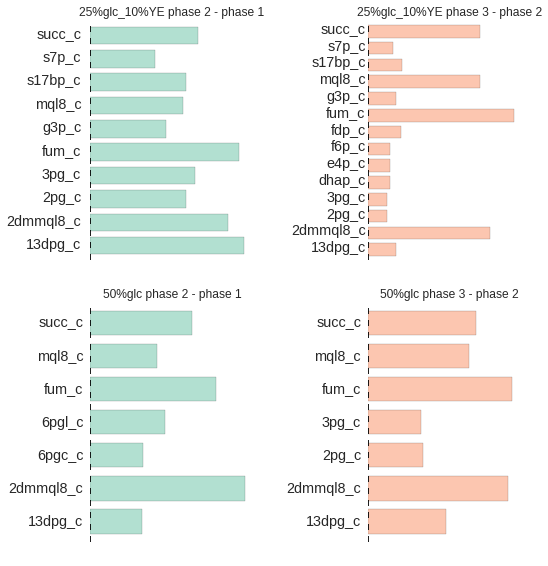

In [93]:
metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'time_course_metabolite_zscores_all_strains'
    
fig, axes = plt.subplots(nrows=2, ncols=2)  # change for adding in bis

c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

strain = "25%glc_10%YE"
df =  DF_metabolite_zscore_p1_p2[strain][~DF_metabolite_zscore_p1_p2[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p1_p2[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p1_p2[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[0,0], kind='barh', color=c1, title=strain + " phase 2 - phase 1",alpha=0.5,figsize=(5, 8))
axes[0,0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0,0].text(-0.25, i + .5, x, ha='right', fontsize='large')


df =  DF_metabolite_zscore_p2_p3[strain][~DF_metabolite_zscore_p2_p3[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p2_p3[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p2_p3[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[0,1], kind='barh', color=c2, title=strain + " phase 3 - phase 2",alpha=0.5,figsize=(5, 8))
axes[0,1].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0,1].text(-0.25, i + .5, x, ha='right', fontsize='large')


strain = "50%glc"
df =  DF_metabolite_zscore_p1_p2[strain][~DF_metabolite_zscore_p1_p2[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p1_p2[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p1_p2[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[1,0], kind='barh', color=c1, title=strain + " phase 2 - phase 1",alpha=0.5,figsize=(5, 8))
axes[1,0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[1,0].text(-0.25, i + .5, x, ha='right', fontsize='large')


df =  DF_metabolite_zscore_p2_p3[strain][~DF_metabolite_zscore_p2_p3[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p2_p3[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p2_p3[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[1,1], kind='barh', color=c2, title=strain + " phase 3 - phase 2",alpha=0.5,figsize=(5, 8))
axes[1,1].axis('off')

for i, x in enumerate(df.metabolite):
        axes[1,1].text(-0.25, i + .5, x, ha='right', fontsize='large')
    
####

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(8)
fig.set_figheight(8)

In [94]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

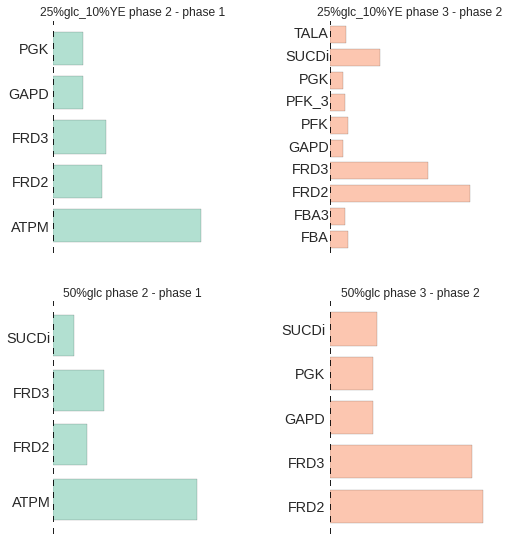

In [95]:
name_graph = 'time_course_reaction_zscores_all_strains'
    
fig, axes = plt.subplots(nrows=2, ncols=2)  # change for adding in bis

c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

strain = "25%glc_10%YE"
df = DF_reaction_zscore_p1_p2[strain][~DF_reaction_zscore_p1_p2[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p1_p2[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p1_p2[strain].reaction.str.contains('pp')][DF_reaction_zscore_p1_p2[strain].z_score > 1.74]

df.z_score.plot(ax=axes[0,0], kind='barh', color=c1, title=strain + " phase 2 - phase 1",alpha=0.5,figsize=(5, 7))
axes[0,0].axis('off')

for i, x in enumerate(df.reaction):
        axes[0,0].text(-0.25, i + .5, x, ha='right', fontsize='large')

df = DF_reaction_zscore_p2_p3[strain][~DF_reaction_zscore_p2_p3[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p2_p3[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p2_p3[strain].reaction.str.contains('pp')][DF_reaction_zscore_p2_p3[strain].z_score > 1.74]

df.z_score.plot(ax=axes[0,1], kind='barh', color=c2, title=strain + " phase 3 - phase 2",alpha=0.5,figsize=(5, 7))
axes[0,1].axis('off')

for i, x in enumerate(df.reaction):
        axes[0,1].text(-0.25, i + .5, x, ha='right', fontsize='large')

strain = "50%glc"
df = DF_reaction_zscore_p1_p2[strain][~DF_reaction_zscore_p1_p2[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p1_p2[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p1_p2[strain].reaction.str.contains('pp')][DF_reaction_zscore_p1_p2[strain].z_score > 1.74]

df.z_score.plot(ax=axes[1,0], kind='barh', color=c1, title=strain + " phase 2 - phase 1",alpha=0.5,figsize=(5, 7))
axes[1,0].axis('off')

for i, x in enumerate(df.reaction):
        axes[1,0].text(-0.25, i + .5, x, ha='right', fontsize='large')

df = DF_reaction_zscore_p2_p3[strain][~DF_reaction_zscore_p2_p3[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p2_p3[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p2_p3[strain].reaction.str.contains('pp')][DF_reaction_zscore_p2_p3[strain].z_score > 1.74]

df.z_score.plot(ax=axes[1,1], kind='barh', color=c2, title=strain + " phase 3 - phase 2",alpha=0.5,figsize=(5, 7))
axes[1,1].axis('off')

for i, x in enumerate(df.reaction):
        axes[1,1].text(-0.25, i + .5, x, ha='right', fontsize='large')

####


fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(8)
fig.set_figheight(8)

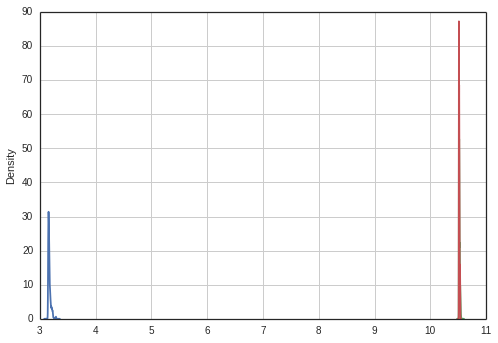

In [96]:
react = 'ATPM'

mcmc_reduced_dict_p1['50%glc'][react].plot(kind='density')
mcmc_reduced_dict_p2['50%glc'][react].plot(kind='density')
mcmc_reduced_dict_p3['50%glc'][react].plot(kind='density')

In [97]:
mcmc_reduced_dict_p1['50%glc'][react]

0     3.15
1     3.15
2     3.15
3     3.15
4     3.15
5     3.15
6     3.15
7     3.15
8     3.15
9     3.15
10    3.15
11    3.15
12    3.15
13    3.15
14    3.15
...
4985    3.20
4986    3.20
4987    3.20
4988    3.20
4989    3.20
4990    3.17
4991    3.17
4992    3.17
4993    3.17
4994    3.17
4995    3.17
4996    3.17
4997    3.17
4998    3.18
4999    3.18
Name: ATPM, Length: 5000, dtype: float64

In [98]:
mcmc_reduced_dict_p1['50%glc'].EX_glc__D_e

0    -1.89
1    -1.89
2    -1.89
3    -1.89
4    -1.89
5    -1.89
6    -1.89
7    -1.89
8    -1.89
9    -1.89
10   -1.89
11   -1.89
12   -1.89
13   -1.89
14   -1.89
...
4985   -1.89
4986   -1.89
4987   -1.89
4988   -1.89
4989   -1.89
4990   -1.89
4991   -1.89
4992   -1.89
4993   -1.89
4994   -1.89
4995   -1.89
4996   -1.89
4997   -1.89
4998   -1.89
4999   -1.89
Name: EX_glc__D_e, Length: 5000, dtype: float64

In [99]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

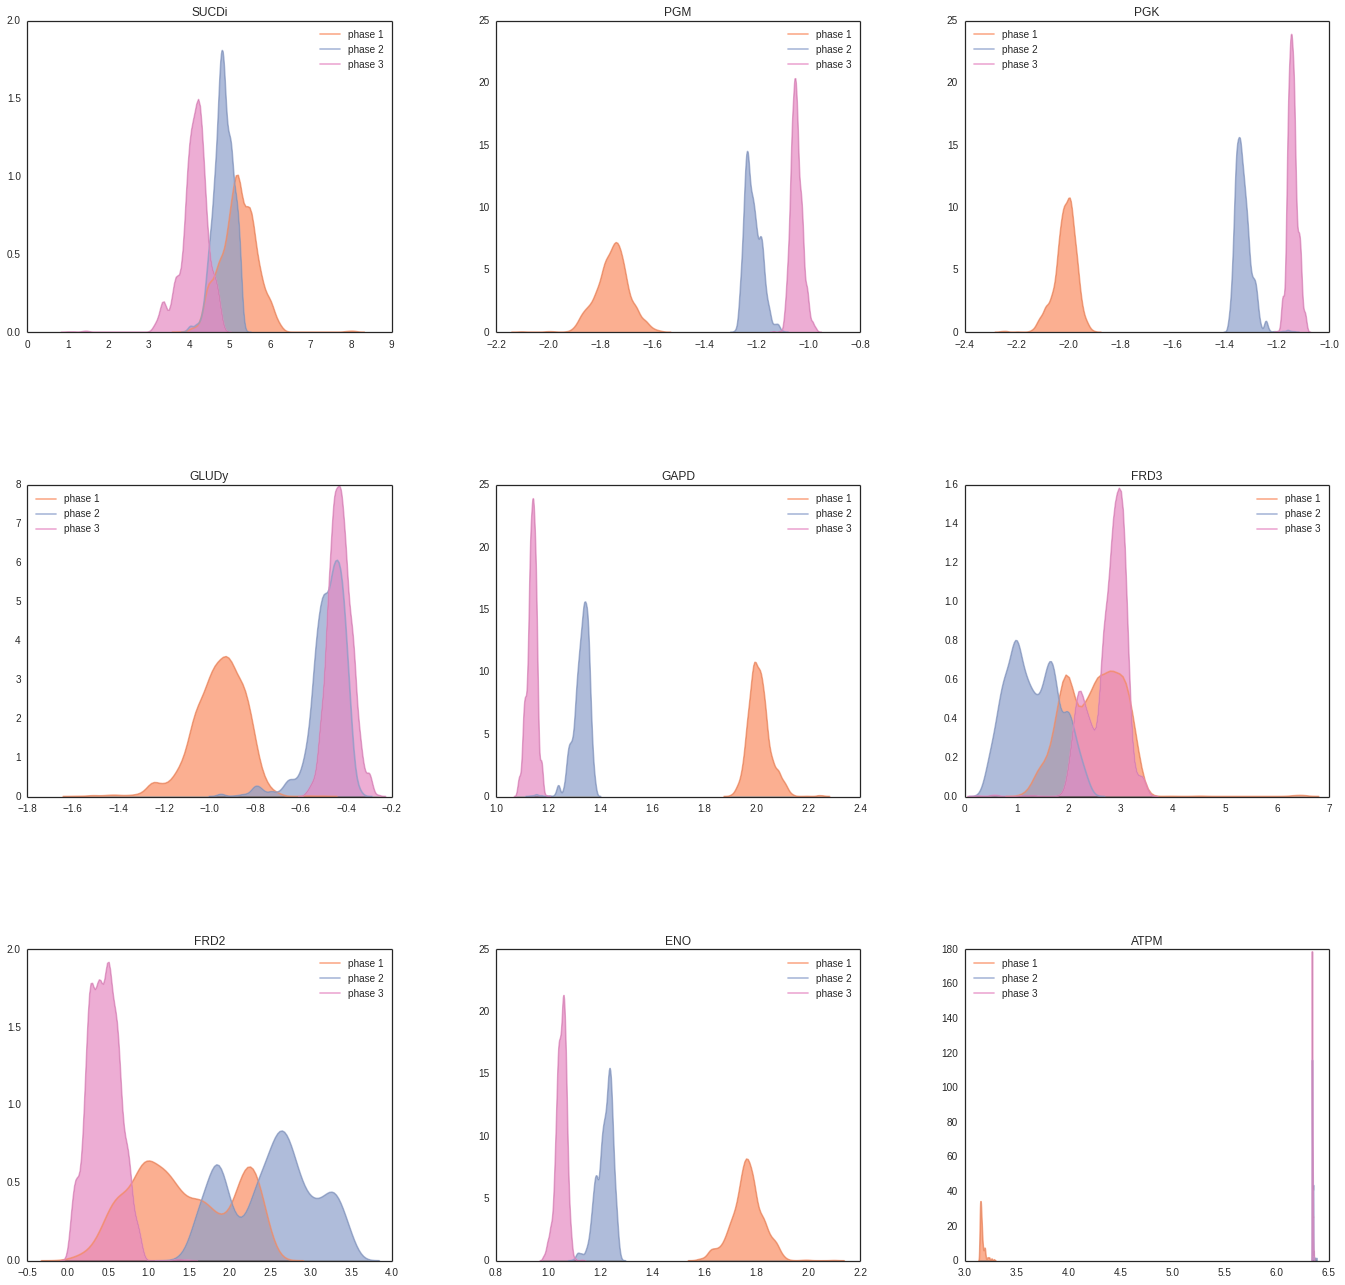

In [100]:
    df1 = mcmc_reduced_dict_p1['25%glc_10%YE']
    df2 = mcmc_reduced_dict_p2['25%glc_10%YE']
    df3 = mcmc_reduced_dict_p3['25%glc_10%YE']
    
    name_graph = '25%glc_10%YE_rxn_shifts'
    
    fig, axes = plt.subplots(nrows=3, ncols=3)  # change for adding in bis
        
    r = 'SUCDi'
    
    #df_tmp[r].plot(kind='density',label=1, ax=axes[0,0],color=sns.color_palette()[0], title=strain)
    #df_tmp2[r].plot(kind='density',label=2,ax=axes[0,0],color=sns.color_palette()[1], title=strain)
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[0,0],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[0,0],label= "phase 3")
   
    axes[0,0].set_title(r)
    
    r = 'PGM'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[0,1],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,1],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[0,1],label= "phase 3")
   
    axes[0,1].set_title(r)

    r = 'PGK'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[0,2],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,2],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[0,2],label= "phase 3")
   
    axes[0,2].set_title(r)
     
    r = 'GLUDy'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[1,0],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,0],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[1,0],label= "phase 3")
   
    axes[1,0].set_title(r)
    
    r = 'GAPD'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[1,1],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,1],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[1,1],label= "phase 3")
   
    axes[1,1].set_title(r)
    
    r = 'FRD3'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[1,2],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[1,2],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[1,2],label= "phase 3")
   
    axes[1,2].set_title(r)
    
    r = 'FRD2'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[2,0],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,0],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[2,0],label= "phase 3")
   
    axes[2,0].set_title(r)
    
    r = 'ENO'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[2,1],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,1],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[2,1],label= "phase 3")
   
    axes[2,1].set_title(r)
    
    r = 'ATPM'
    
    sns.kdeplot(df1[r], shade=True, color=c2, alpha=0.7,ax=axes[2,2],label= "phase 1");
    sns.kdeplot(df2[r], shade=True, color=c3, alpha=0.7,ax=axes[2,2],label= "phase 2")
    sns.kdeplot(df3[r], shade=True, color=c4, alpha=0.7,ax=axes[2,2],label= "phase 3")
   
    axes[2,2].set_title(r)
    
    fig.tight_layout()

    fig = plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(20)

In [101]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')